# giger analysis
**BY** : erez ben yakov
nucler radietion exspiremnt - lab 2b 
**Description:**
this notebook is finding the dead time of the giger counter , by finding the sortest dip, we clean the noisr by FFT and return the data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import find_peaks
# Configure plot style for professional reports
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

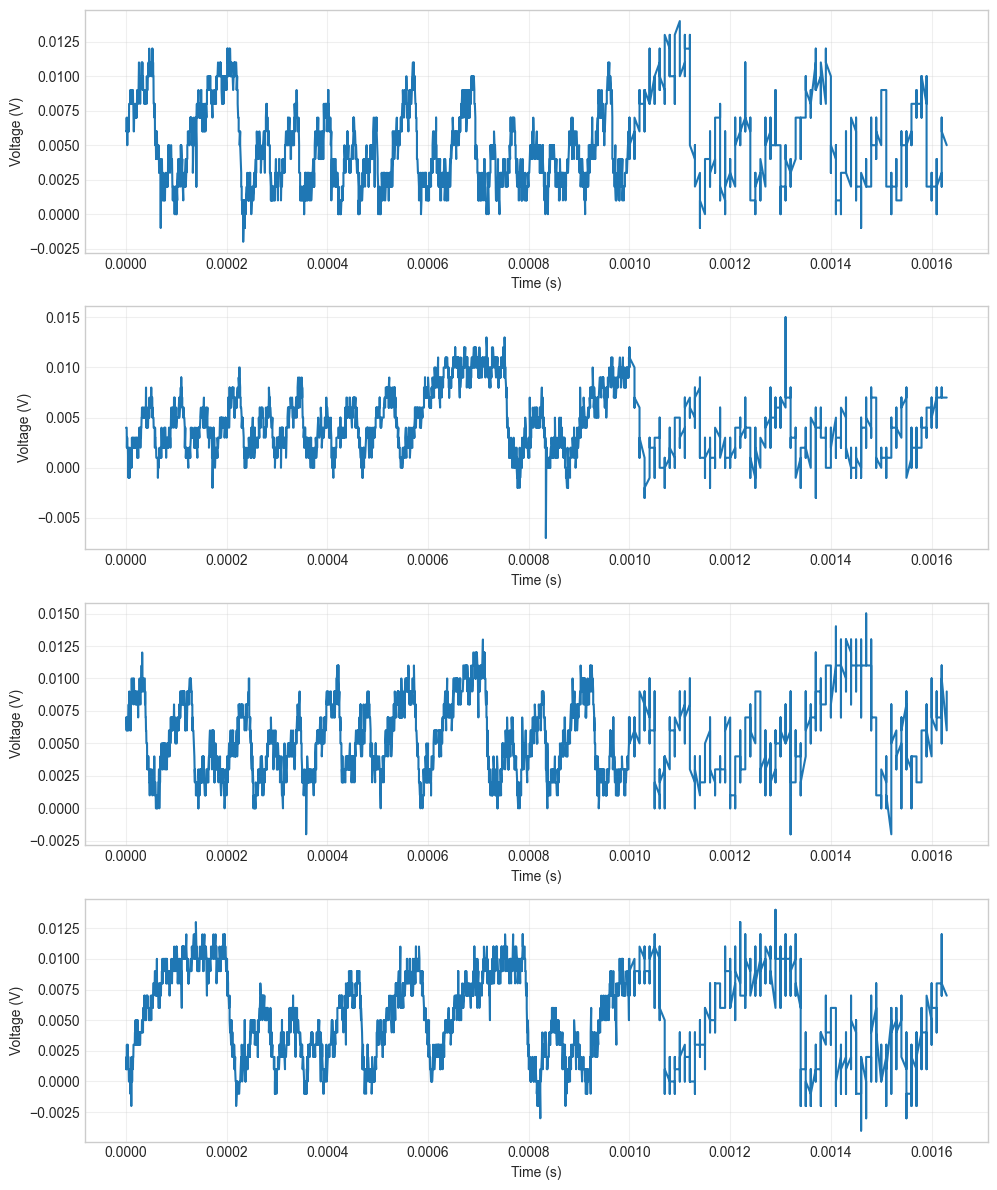

In [8]:
#loading data and show it 
#this is ny files name you put yours.
filenames = ["data/WaveData101.csv",
            "data/WaveData111.csv",
            "data/WaveData112.csv",
            "data/WaveData113.csv",]

data_lab_radiation = []
for file in filenames:
    try:
        df = pd.read_csv(file, skiprows=3,header=None, names=['time', 'voltage'])
        data_lab_radiation.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(10,12))
axes = axes.flatten()

for i,ax in enumerate(axes):
    ax.plot(data_lab_radiation[i]['time'],data_lab_radiation[i]['voltage'])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")
    ax.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()


## Methodology: Frequency Domain Filtering
To measure the dead time accurately, we must remove the high-frequency noise inherent in the raw oscilloscope data.
1. **FFT:** Convert voltage signal to frequency domain.
2. **Low-Pass Filter:** Cut off frequencies above **100 kHz** (noise).
3. **IFFT:** Reconstruct the smooth signal.
4. **Peak Detection:** Identify local minima (dips) and calculate the time difference ($\Delta t$) between them.

Dataset 1: Minimum time difference between peaks: 1.80e-05 s
Dataset 2: Minimum time difference between peaks: 1.70e-05 s
Dataset 3: Minimum time difference between peaks: 1.80e-05 s
Dataset 4: Minimum time difference between peaks: 1.00e-05 s


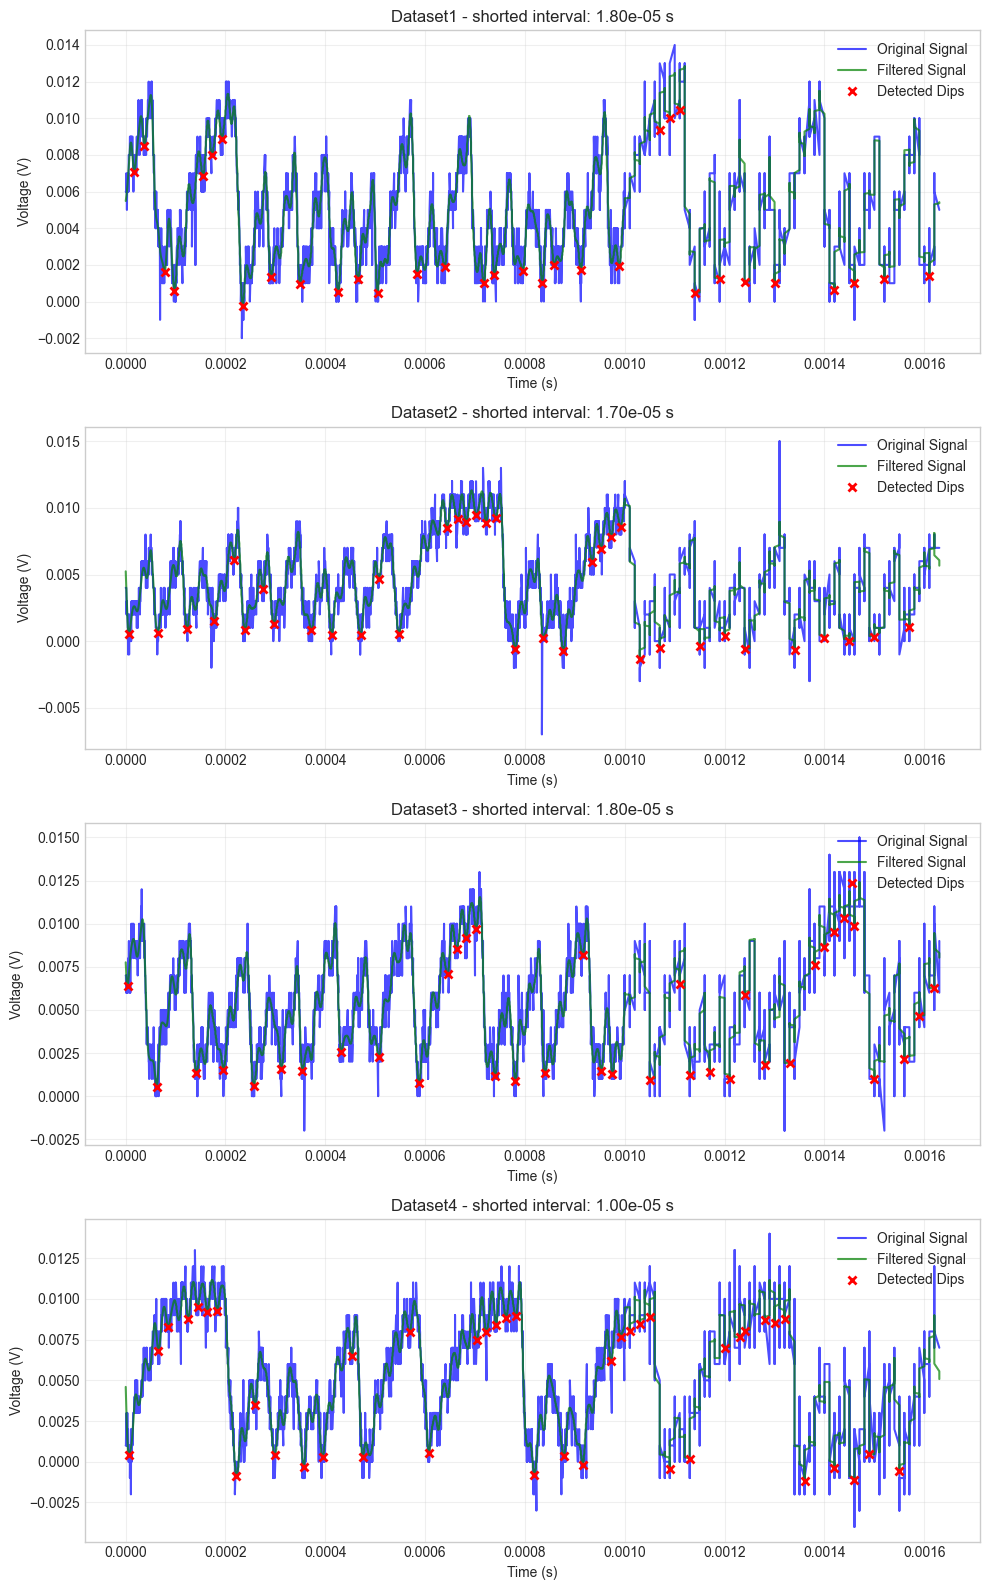

In [9]:
# Parameters
cutoff_freq = 100000  # 100 kHz Cutoff
prominence_ratio = 0.1 # Peak must differ by 10% of range to be counted

# Create a figure for the subplots
fig, axes = plt.subplots(nrows=len(filenames), ncols=1, figsize=(10, 16))
axes = axes.flatten()

for i,df in enumerate(data_lab_radiation):
    #DATA
    t = df['time'].values
    v = df['voltage'].values
    N = len(v)
    dt = t[1] - t[0]  # assuming uniform spacing

    #FFT
    yf = rfft(v)
    xf = rfftfreq(N, dt)

    #CUTOFF
    yf_cutoff = yf.copy()
    yf_cutoff[xf > cutoff_freq] = 0

    #RFFT
    v_filtered = irfft(yf_cutoff)

    #PEAK FINDING
    # we invert the signal to find peaks , giger give use dips
    v_inverted = -v_filtered
    prominence = (v_inverted.max() - v_inverted.min()) * prominence_ratio  # 10% of the signal range
    peaks, _ = find_peaks(v_inverted, prominence=prominence)

    #find shortest peaks time difference
    if len(peaks) > 1:
        peak_time = t[peaks]
        time_diffs = np.diff(peak_time)
        min_time_diff = np.min(time_diffs)
        print(f"Dataset {i+1}: Minimum time difference between peaks: {min_time_diff:.2e} s")

    #plotting
    ax = axes[i]
    ax.plot(t, v, label='Original Signal', color='blue', alpha=0.7)
    ax.plot(t, v_filtered, label='Filtered Signal', color='green', alpha=0.7)
    if len(peaks) > 0:
        ax.plot(t[peaks], v_filtered[peaks], "x", markeredgewidth=2, label='Detected Dips', color='red')
    ax.set_title(f"Dataset{i+1} - shorted interval: {min_time_diff:.2e} s")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
